## Exploring Data from Wake Island

Arnie Larson<br/>
March 28,2023

### Notes on exploring hydrophone data coming from Wake Island from the IRIS data portal

The Wake Island seismic data is collected by the [CRBTO](https://www.ctbto.org/), as part of the Nulcear Test Ban Treaty.  The data is available via a web service, accessible with a simple Java program made availabe from [IRIS](http://ds.iris.edu/ds/nodes/dmc/manuals/iris-ws/#barebones), a consortium of universities providing some management of seismic data, now known as the [EarthScope Consortium](https://www.earthscope.org/).  The hydrophone sources come with a sensitivity parameter (Units of \[count/Pa\]) which I use as a scalar calbiration to convert from raw ADC values to Pa.   The collected data is effectively downsampled to $f_s = 250 Hz$, and for frequencies lower than 10 Hz this calibration is not necessarily accurate.


<B>Wake Island Stations</B>

- Station, Latitude,  Longitude,  elevation
- H11N1, 19.7136, 166.8911, -731
- H11N2, 19.7308, 166.9977, -732
- H11N3, 19.7172, 166.9100, -729
- H11S1, 18.5083, 166.7002, -750
- H11S2, 18.4908, 166.7050, -742
- H11S3, 18.4957, 166.6865, -726

### Kauai Island Source

There is an interesting source near Kauai Island, Hawaii, [Kauai Source](http://marasondo.org/) that was recently put back online.

This source sends out intermittantly a 20 minute broadband signal centered at 75 Hz.  The sequences of data modulated onto the signal are <B>M Sequences</B> using law 3471 which has excellent matched filter properties so that the wave forms can be extracted from the data for the purpose of doing climate research via ocean acoustic tomography.  These M Sequences are expected to be 1023 digits long, and with a center frequency of $f_c = 75 Hz$, each symbol is expected to have 2 cycles duration $T_S = 2/f_c \approx 26.7ms$, and bandwidth $\approx 1/T_S = 37.5 Hz$, and a total sequence time of about $1023 \times T_S \approx 27s$.  A little more information about the source and related experiments can be found [here](https://apl.uw.edu/projects/npal/index.php)

I a not 100% sure the best way to perform the matched filter.  Playing around with phase shifts and doppler shifts I did notice that there is a tremendous reduction in the matched filter output for any type of doppler shifting.  Presumably currents can have doppler effects on waveforms.

With suggestions from John Mower, and notes and assistance from David Dall'Osto and Rex Andrews I wanted to see if I'd be able to see these waveform in the hydrophone data.

### Highlights

- xyz
- abc

### Todo

- \[ \] Look at noise PSD, integrated NL
- \[ \] Systematically look for signal on 3/18 for N1, N2, N3, S1, S2, S3

### Other Tests

While waiting for the data to come online I also looked for some other potentially interesting data.

There was an earthquake in Turkey on February 6, 2023 at 01:17 UTC.   I did not see any obvious evidence of this in the data.

In Tonga there was an underwater volcano on December 15, 2021.  I did see some impulsive short duration blips in the data.

The ATOC project testing was peformed in December 2022, but I did not find any signal in the data for these tests.
- 12/01/2022 at 11:00:00; 23:00:00
- 12/02/2022 at 11:00:00; 23:00:00
- 12/03/2022 at 11:00:00; 23:00:00
- 12/04/2022 at 11:00:00; 23:00:00




In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.fft import fft, fftfreq
import scipy.signal as signal
import scipy.io as io
import os

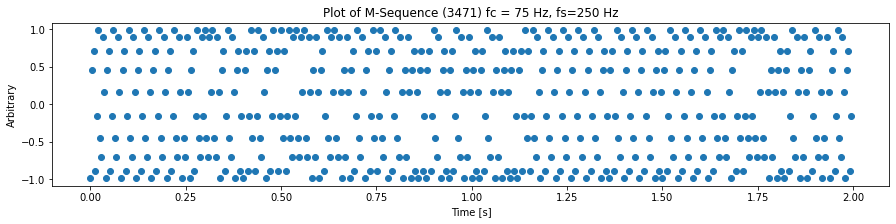

In [10]:
# M Sequence - generate the M3471 signal for correlations

fs=250
tm, mtest = make_signal(m3471, 2, 75, fs, 30)
plt.subplots(figsize=(15,3))
plt.title("Plot of M-Sequence (3471) fc = 75 Hz, fs=250 Hz")
plt.plot(tm[:500], mtest[:500], 'o')
plt.xlabel("Time [s]"); plt.ylabel("Arbitrary")
plt.show()

In [23]:
# Generate doppler shifted m sequences
fc = 75
delta = np.arange(-0.2, 0.2, 0.02)
m = np.zeros((delta.shape[0], mtest.shape[0]))
for i in range(delta.shape[0]):
    m[i,:] = make_signal(m3471, 2, fc+delta[i], fs, 30.0, False)
    

In [24]:
m[0,0]

-0.9880316240928618

In [14]:
# Look for M Sequences at Wake Island - 3/22

station="H11S1"
files = [x for x in ls(station) if x.startswith("2023-03-22") or x.startswith("2023-03-21")] 
files
p,t=load_files(station,files)

Loading: 2023-03-21 22:00:00.002.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1050000 points
Loading: 2023-03-21 23:10:00.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1972500 points
Loading: 2023-03-22 01:21:30.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1975000 points
Loading: 2023-03-22 03:33:10.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1970000 points
Loading: 2023-03-22 05:44:30.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1967500 points
Loading: 2023-03-22 07:55:40.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1970000 points
Loading: 2023-03-22 10:07:00.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
Generated 1970000 points
Loading: 2023-03-22 12:18:20.003.txt
Normalizing with sensitivity: 1860.86 count/Pa [output is in uPa]
G

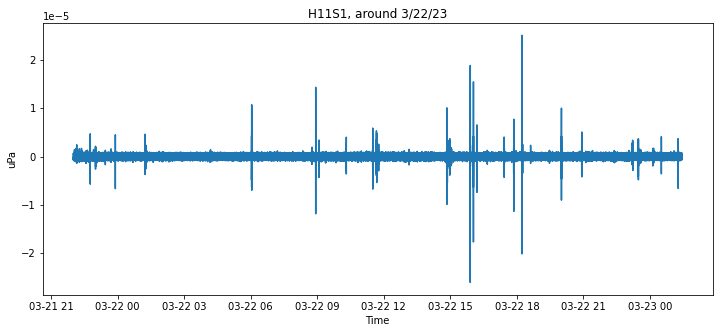

In [25]:
# Loop throught the doppler shifted waveforms and plot autocorrelations
plt.subplots(figsize=(12,5))
plt.title("H11S1, around 3/22/23")
plt.xlabel("Time"); plt.ylabel("uPa")
plt.plot(t,p)
plt.show()

In [26]:
# look for correlation
# Let's subset the data a little, 
tstart1 = np.datetime64("2023-03-21T23:30:00.001")
tend1 = np.datetime64("2023-03-22T08:30:00.001")
c1 = np.logical_and(t > tstart1, t < tend1)
a = np.zeros((m.shape[0], p[c1].shape[0]))
for idx in range(m.shape[0]):
    a[idx,:] = signal.correlate(p[c1], m[idx], mode='same', method='direct')/fs

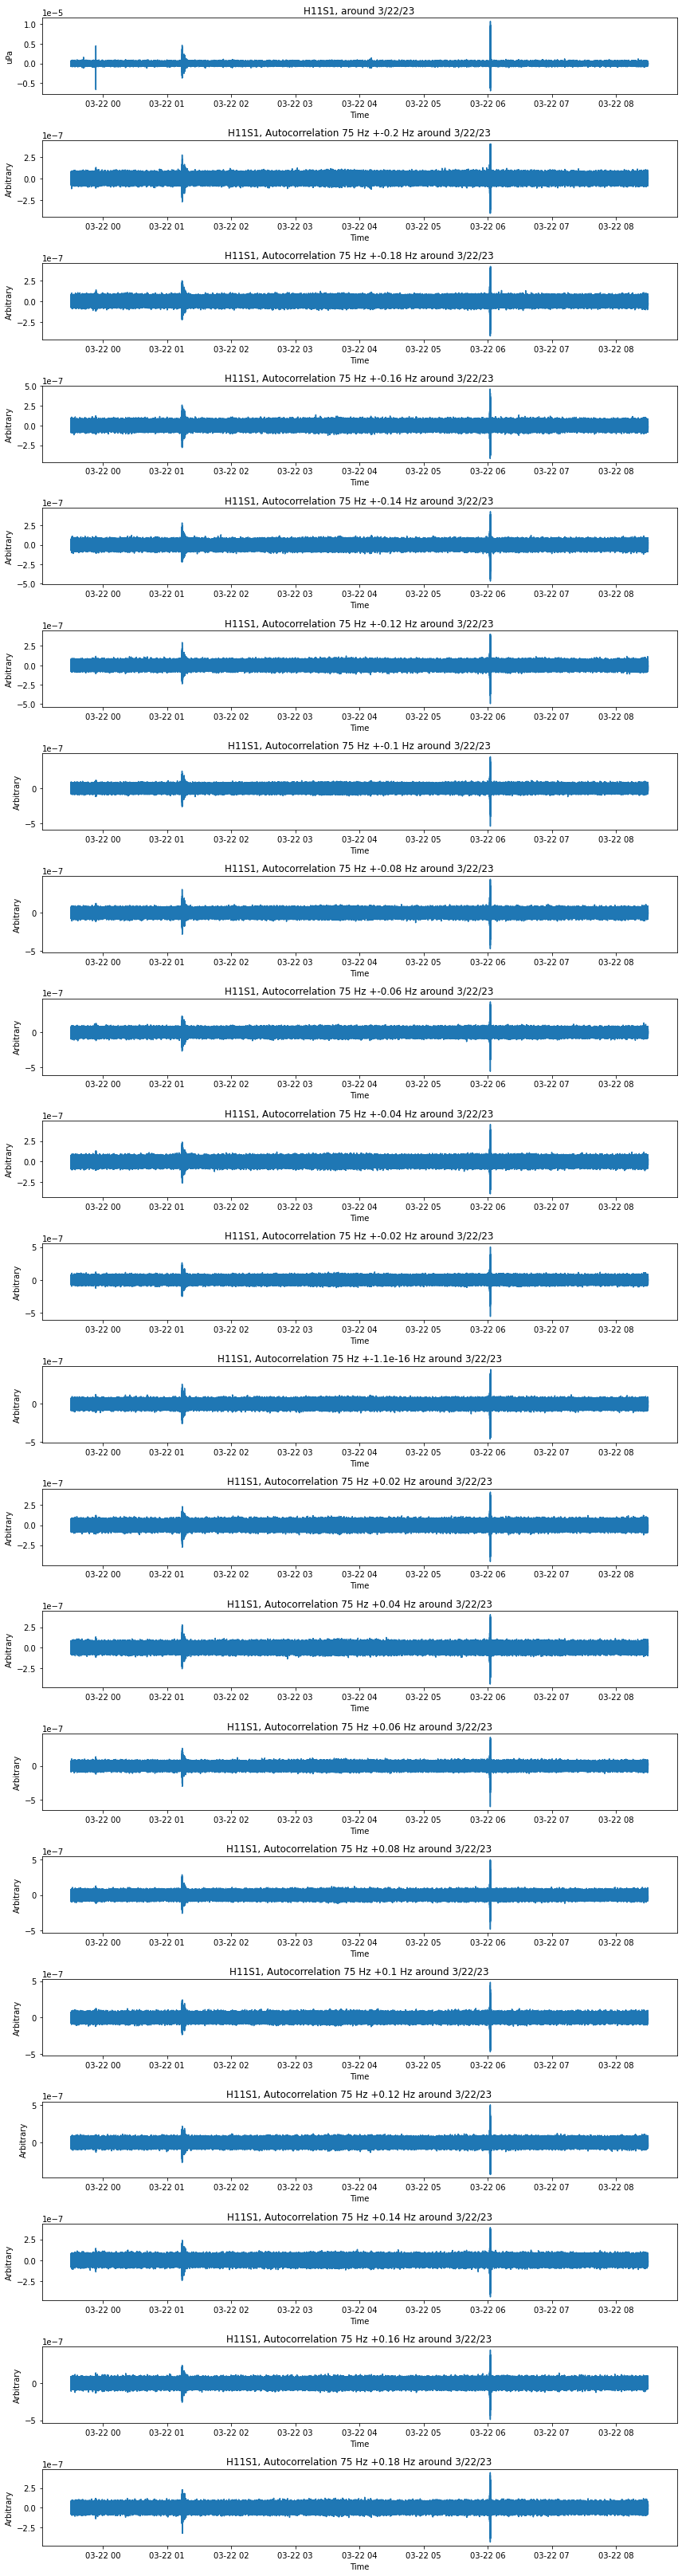

In [27]:
# Loop throught the doppler shifted waveforms and plot autocorrelations
fig, ax = plt.subplots(m.shape[0]+1,1,figsize=(12,45))
ax[0].set_title("H11S1, around 3/22/23")
ax[0].set_xlabel("Time"); ax[0].set_ylabel("uPa")
ax[0].plot(t[c1],p[c1])
for idx in range(m.shape[0]):
    ax[idx+1].set_title("H11S1, Autocorrelation {} Hz +{:.2} Hz around 3/22/23".format(fc, delta[idx]))
    ax[idx+1].set_xlabel("Time"); ax[idx+1].set_ylabel("Arbitrary")
    ax[idx+1].plot(t[c1],a[idx,:])


plt.tight_layout()
plt.show()

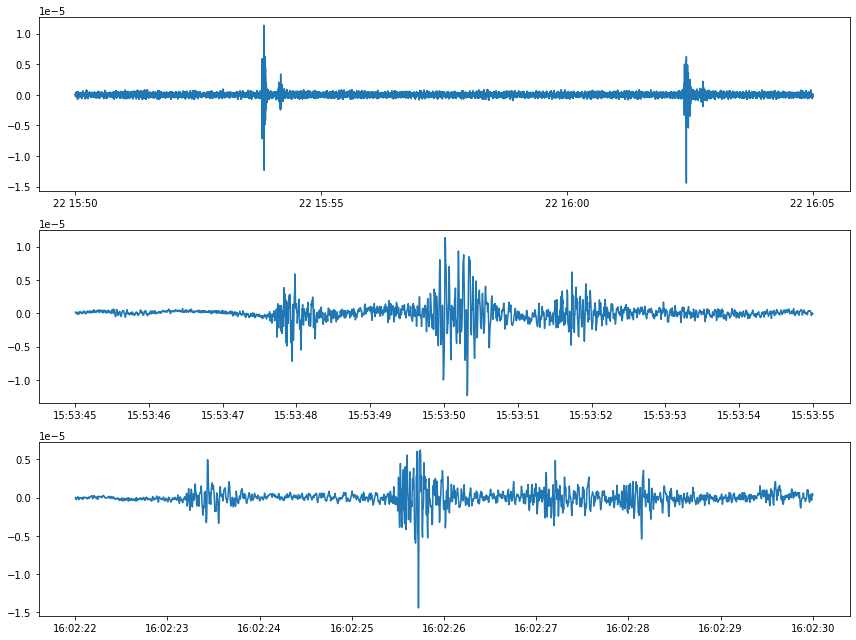

In [138]:
# Autocorrelation just seeing the blips in the data.  I'll zoom in a few of the blips
# Kind of interesting, likely ships since they appear to be fairly broadband blips?

tstart1 = np.datetime64("2023-03-22T15:50:00.001")
tend1 = np.datetime64("2023-03-22T16:05:00.001")
c1 = np.logical_and(t > tstart1, t < tend1)
tstart2 = np.datetime64("2023-03-22T15:53:45.001")
tend2 = np.datetime64("2023-03-22T15:53:55.001")
c2 = np.logical_and(t > tstart2, t < tend2)
tstart3 = np.datetime64("2023-03-22T16:02:22.001")
tend3 = np.datetime64("2023-03-22T16:02:30.001")
c3 = np.logical_and(t > tstart3, t < tend3)

fig, (a1,a2,a3) = plt.subplots(3,1,figsize=(12,9))
a1.plot(t[c1],p[c1])
a2.plot(t[c2],p[c2])
a3.plot(t[c3],p[c3])
plt.tight_layout()
plt.show()

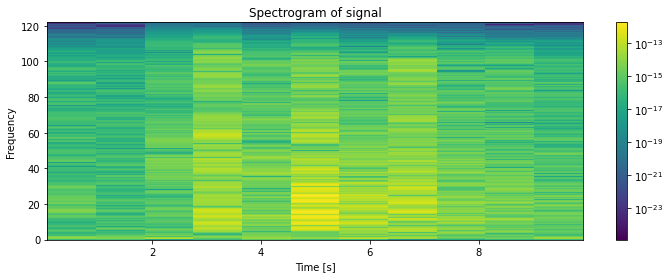

In [139]:
# look at the spectrogram from the 2 zoomed in signals?  Signals are fairly broadband, ship?

plot_spec(p[c2], np=256, nfft=1024, idx=500)

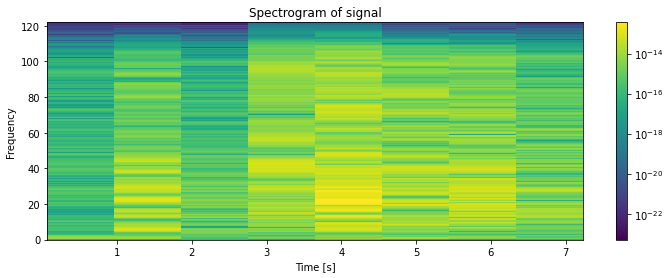

In [140]:
# look at the spectrogram from the 2nd zoomed in signal
# Again signals are fairly broadband, ship?
plot_spec(p[c3], np=256, nfft=1024, idx=500)

In [152]:
# Look for M Sequences at Wake Island - 3/22

station="H11S3"
files = [x for x in ls(station) if x.startswith("2023-03-22") or x.startswith("2023-03-23")] 
files
p,t=load_files(station,files,output=False)

In [154]:
# look for correlation
a = signal.correlate(p, m3471, mode='same', method='direct')/fs

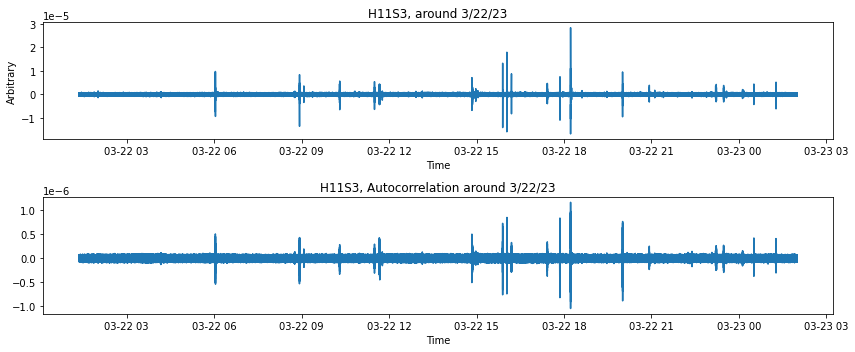

In [156]:
fig, (a0,a1) = plt.subplots(2,1,figsize=(12,5))
a0.set_title("H11S3, around 3/22/23")
a0.set_xlabel("Time"); a0.set_ylabel("uPa")
a0.plot(t,p)
a1.set_title("H11S3, Autocorrelation around 3/22/23")
a1.set_xlabel("Time"); a0.set_ylabel("Arbitrary")
a1.plot(t,a)

plt.tight_layout()
plt.show()

In [183]:
# Look for M Sequences at Wake Island - 3/18

station="H11S1"
files = [x for x in ls(station) if x.startswith("2023-03-21") or x.startswith("2023-03-22")] 
files
p,t=load_files(station,files,output=False)

In [184]:
a = signal.correlate(p, m3471, mode='same', method='fft')/fs

In [186]:
mfir = m3471[::-1]
a = signal.lfilter(mfir, 1, p)

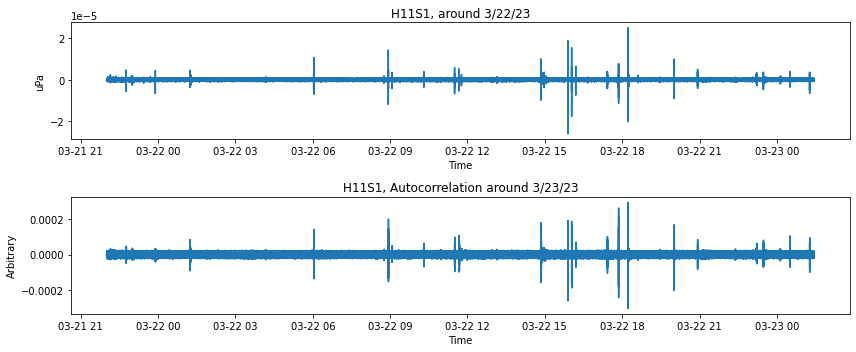

In [187]:
fig, (a0,a1) = plt.subplots(2,1,figsize=(12,5))
a0.set_title("H11S1, around 3/22/23")
a0.set_xlabel("Time"); a0.set_ylabel("uPa")
a0.plot(t,p)
a1.set_title("H11S1, Autocorrelation around 3/23/23")
a1.set_xlabel("Time"); a1.set_ylabel("Arbitrary")
a1.plot(t,a)

plt.tight_layout()
plt.show()

In [174]:
# Look for M Sequences at Wake Island - 3/18

station="H11N2"
files = [x for x in ls(station) if x.startswith("2023-03-17") or x.startswith("2023-03-18")] 
files
p,t=load_files(station,files,output=False)

In [177]:
a = signal.correlate(p, m3471, mode='same', method='direct')/fs

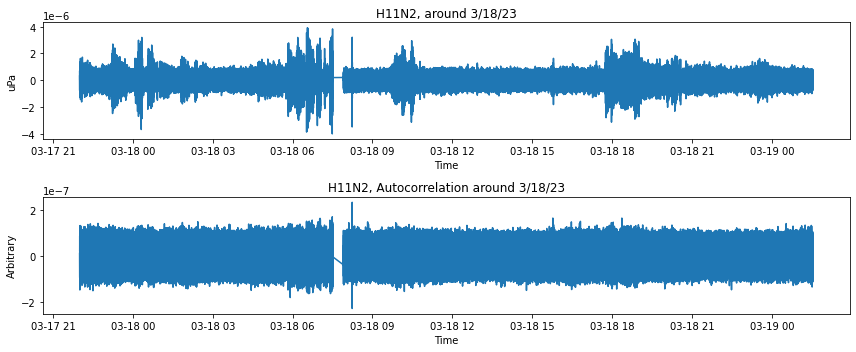

In [178]:
fig, (a0,a1) = plt.subplots(2,1,figsize=(12,5))
a0.set_title("H11N2, around 3/18/23")
a0.set_xlabel("Time"); a0.set_ylabel("uPa")
a0.plot(t,p)
a1.set_title("H11N2, Autocorrelation around 3/18/23")
a1.set_xlabel("Time"); a1.set_ylabel("Arbitrary")
a1.plot(t,a)

plt.tight_layout()
plt.show()

## Can I see seismic data from the earthquake in Turkey?

### Discussion

I examined a variety of data around 2/06/23 looking for signs of the earthquake(s) in Turkey

In [17]:
# Data taken around earthquake in Turkey, no idea what these blips are late on 02/06/23
station="H11S1"
files = [x for x in ls(station) if x.startswith("2023-02-06")] # or x.startswith("2023-03-18") ]
files
p,t=load_files(station,files)

Loading: 2023-02-06 16:11:00.0.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 297500 points
Loading: 2023-02-06 16:30:50.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-06 18:42:10.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-06 20:53:30.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-06 23:04:50.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1972500 points


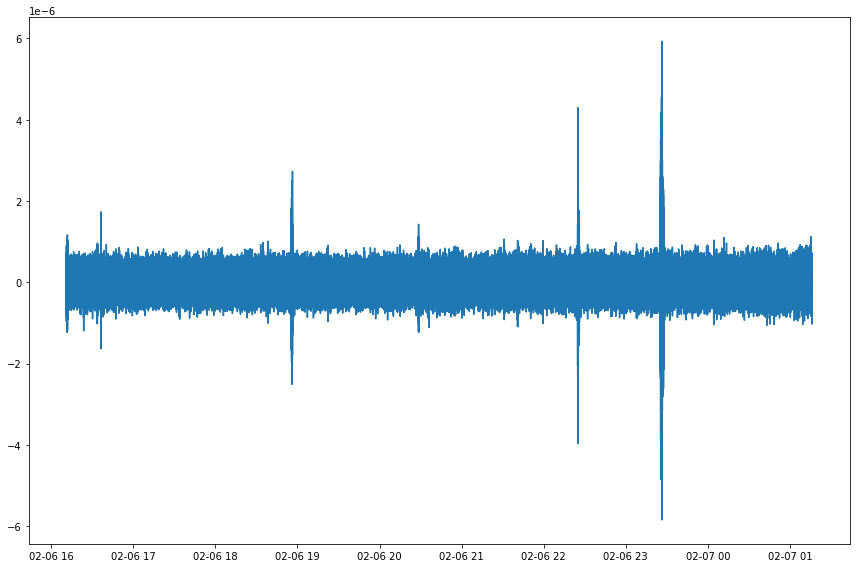

In [18]:
plt.subplots(figsize=(12,8))
plt.plot(t,p)
plt.tight_layout()
plt.show()

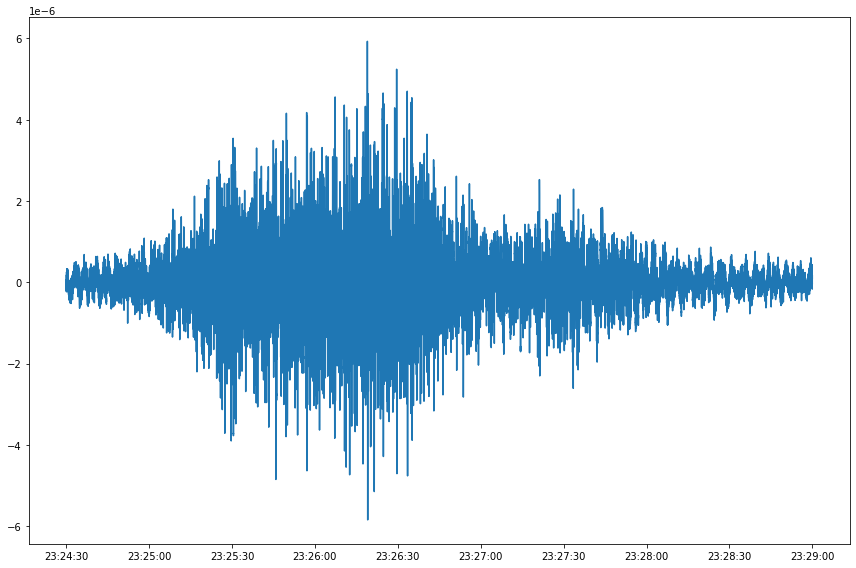

In [25]:
# Some big blips, I'll zoo in on the one between 02/06:23 and 02/07:00
tstart = np.datetime64("2023-02-06T23:24:30.001")
tend = np.datetime64("2023-02-06T23:29:00.001")
cond1 = t > tstart
cond2 = t < tend
cond3 = np.logical_and(cond1, cond2)
plt.subplots(figsize=(12,8))
plt.plot(t[cond3],p[cond3])
plt.tight_layout()
plt.show()

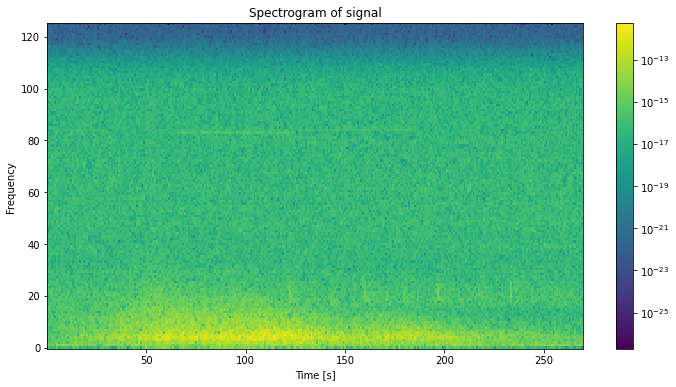

In [29]:
# defaults to saple rate of 250Hz
plot_spec(p[cond3])

In [30]:
# Data taken around earthquake in Turkey, that's kind of interesting
station="H11S1"
files = [x for x in ls(station) if x.startswith("2023-02-05")] # or x.startswith("2023-03-18") ]
p,t=load_files(station,files)
p.shape

Loading: 2023-02-05 00:29:40.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1972500 points
Loading: 2023-02-05 02:41:10.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-05 04:52:30.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1967500 points
Loading: 2023-02-05 07:03:40.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-05 09:15:00.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1970000 points
Loading: 2023-02-05 11:26:20.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1972500 points
Loading: 2023-02-05 13:37:50.003.txt
Normalizing with sensitivity: 1860.86 Pa/count [Note, output is in uPa]
Generated 1975000 points
Loading: 2023-02-05 15:49:30.003.txt
Normalizing with sensitiv

(16305000,)

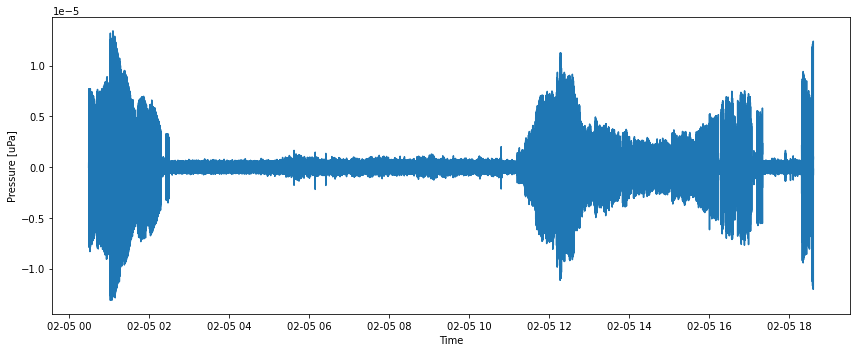

In [33]:
plt.subplots(figsize=(12,5))
plt.plot(t,p)
plt.xlabel("Time"); plt.ylabel("Pressure [uPa]")
plt.tight_layout()
plt.show()

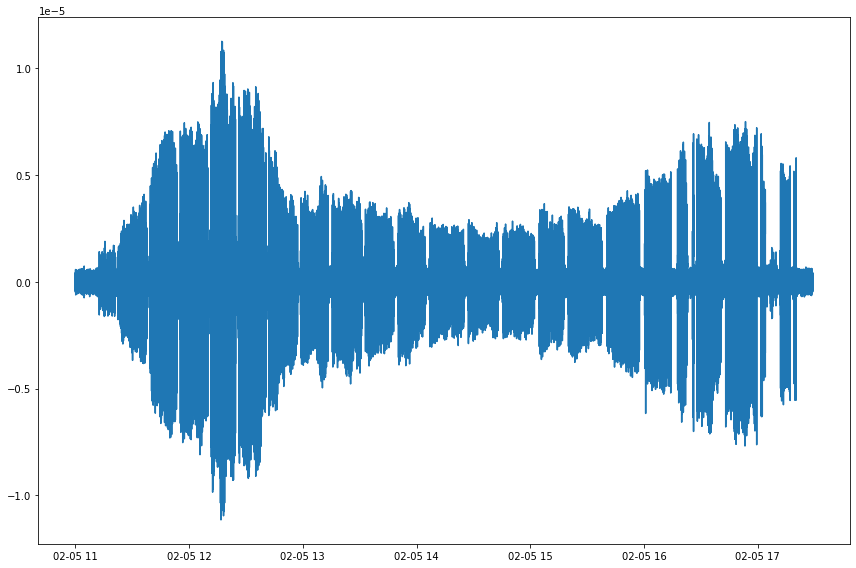

In [32]:
# Interesting stuff seen in this data
tstart = np.datetime64("2023-02-05T11:00:00.001")
tend = np.datetime64("2023-02-05T17:29:00.001")
cond1 = t > tstart
cond2 = t < tend
cond3 = np.logical_and(cond1, cond2)
plt.subplots(figsize=(12,6))
plt.plot(t[cond3],p[cond3])
plt.tight_layout()
plt.show()

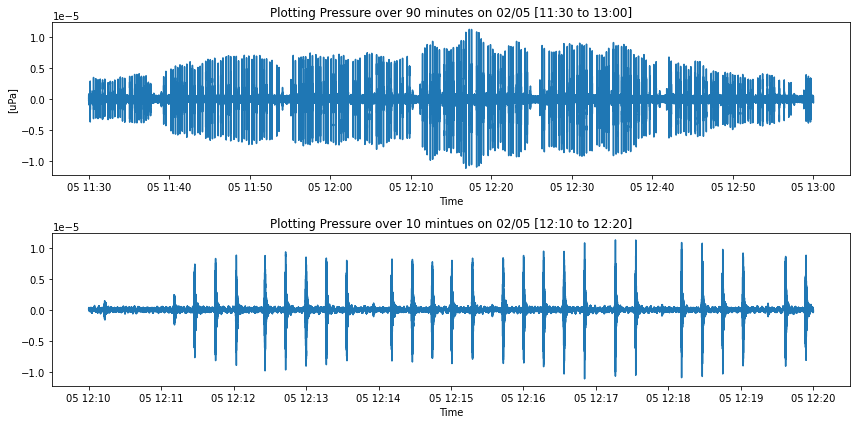

In [36]:
# Interesting stuff seen in this data, let's zoom in on it a little
tstart = np.datetime64("2023-02-05T11:30:00.001")
tend = np.datetime64("2023-02-05T13:00:00.001")
cond1 = t > tstart
cond2 = t < tend
cond3 = np.logical_and(cond1, cond2)
tstart2 = np.datetime64("2023-02-05T12:10:00.001")
tend2 = np.datetime64("2023-02-05T12:20:00.001")
cond4 = t > tstart2
cond5 = t < tend2
cond6 = np.logical_and(cond4, cond5)

fig, (a1,a2) = plt.subplots(2,1, figsize=(12,6))
a1.set_title("Plotting Pressure over 90 minutes on 02/05 [11:30 to 13:00]")
a1.plot(t[cond3],p[cond3])
a1.set_xlabel("Time"); a1.set_ylabel("[uPa]")
a2.set_title("Plotting Pressure over 10 mintues on 02/05 [12:10 to 12:20]")
a2.plot(t[cond6],p[cond6])
a2.set_xlabel("Time"); a1.set_ylabel("[uPa]")

plt.tight_layout()
plt.show()

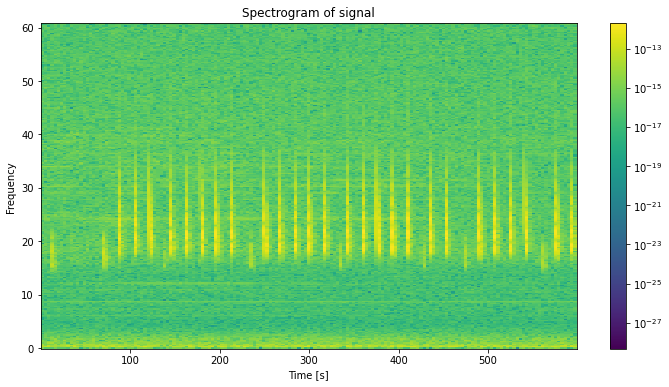

In [38]:
# Whale volcalizations over 10 minutes
plot_spec(p[cond6], np=1024)

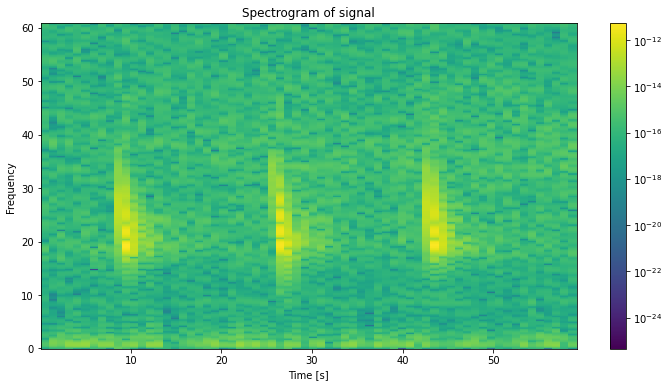

In [67]:
# Whale volcalizations over 1 minutes, linear frequency modulation?   Baleen whale?
tstart = np.datetime64("2023-02-05T12:21:00.001")
tend = np.datetime64("2023-02-05T12:22:00.001")
cond1 = t > tstart
cond2 = t < tend
cond3 = np.logical_and(cond1, cond2)

# Added some zero padding and adjusted the index to see the appropriate frequency scale
plot_spec(p[cond3], np=256, nfft=2*1024, idx=500)

In [7]:
##############################################################################
#
# Generate M Sequences
#
# 1. Rex Andrews sent me some information and codes for processing these
# 2. I ultimately just wrote some of the generated sequences to disk to use
# 3. Here I load the sequences as {1,0}'s from disc
# 4. I then force sequences into {1,-1}'s
# 5. The signal is effectively a BPSK modulation *(binary phase shift key)
# 6. I then generate waveforms for the law, center frequency and sample rate
# 
#
##############################################################################


### Load stored sequenecs => np arrays
f1 = open(os.path.join(os.getcwd(),"rex/msequence/s1333.txt"))
f2 = open(os.path.join(os.getcwd(),"rex/msequence/s3471.txt"))
m1333 = np.array([int(x) for x in f1.readline().rstrip(",").split(",")])
m3471 = np.array([int(x) for x in f2.readline().rstrip(",").split(",")])
f1.close(); f2.close()


 
# Generate a m-sequence waveform
#
# m:    [1,-1] version of digital signal
# Q:    basically the length of each symbol
# fc:   center frequency
# fs:   signal sample rate
# phi:  phase shift
def make_signal(m, Q, fc, fs, phi=0.0,tax=True):
    # Wake Island Data: #fc=75 Hz;   fs=250 Hz;   
    Ts=Q/fc          # note hard coding - too many little bugs
    tend = m.shape[0]*Q/75 - 1/fs   # doppler = 0 time
    N = int(fs*m.shape[0]*Q/75)     # doppler = 0 N
    # could start this in negative time to create a lag if desired...
    t=np.linspace(0, tend, N)
    p=np.zeros(t.shape[0])

    # Still havent thought of a way to modulate sequence without a loop
    for i in range(t.shape[0]):
        if t[i] >= 0:
            sidx = int(np.floor(t[i]/Ts))     # Get the index into the m sequence
            if sidx < m.shape[0]:             # Update the pulse based
                p[i] = np.sin(2*np.pi*fc*t[i] + phi+np.pi*m[sidx])
    if tax:
        return t, p
    else:
        return p

In [8]:
##############################################################################
#
# Load hydrophone data 
#
##############################################################################


# 1. Parses first 2 lines for start time, sensitivity, sample rate
# 2. Normalizes data (remove the mean, apply calibration to get units uPa)
# 3. Generate and also return corresponding time series
def load_norm(station, fname, output=True):
    filepath="/Users/arnie/Documents/EE/Code/IRIS/data/IRIS/IM/"+station+"/"+fname

    st = None  # start time for time series
    sensitivity = 1.0    # Sensitivity, calibrates counts to Pa (raw value is Pa/count)
    fs = 100.0 # Sample rate
    i=0        # N = i - 1
    p=[]
    for line in open(filepath).readlines():
        if i < 2:
            #print("{}".format(line))
            if i==1:
                vals = line.split()
                sensitivity = np.float32(vals[6])*1e6
                st = np.datetime64(vals[2]+"T"+vals[3])
                fs = np.float32(vals[4])
            i+=1
        else:
            try:
                p.append(np.float32(line))
                i+=1
            except:
                print("Error processing: {}".format(line))
    
    # Convert pressure to uPa
    p = np.array(p)
    p = p - p.mean()
    p/=sensitivity
    # Generate a time series, expected time detla to be 0.004 ms
    td = np.timedelta64(int(1000/fs), 'ms')
    t = np.arange(st, st+(i-2)*td, td)
    if output: print("Normalizing with sensitivity: {:.2f} count/Pa [output is in uPa]".format(sensitivity*1e-6))
    if output: print("Generated {} points".format(i-2))
    return p,t

# Somewhat dumb helper loading functions, enables a test condition 
# then attempts to load the data in chronological order (sorted by alpha)
# and concatenate the results
def load_files(station, files, output=True):
    p=[]; t =[]
    for f in sorted(files):
        if output: print("Loading: {}".format(f))
        (p1, t1) = load_norm(station, f, output)
        p.append(p1)
        t.append(t1)
    p=np.concatenate(p)
    t=np.concatenate(t)
    return p,t

def ls(station):
    p="/Users/arnie/Documents/EE/Code/IRIS/data/IRIS/IM/"+station
    return os.listdir(p)

def load_cond1(station, cond1):
    p=[]; t =[]
    files = [x for x in ls(station) if x.startswith(cond1) ]
    for f in sorted(files):
        print("Loading: {}".format(f))
        (p1, t1) = load_norm(station, f)
        p.append(p1)
        t.append(t1)
    p=np.concatenate(p)
    t=np.concatenate(t)
    return p,t

def load_cond2(station, cond1, cond2):
    p=[]; t =[]
    files = [x for x in ls(station) if x.startswith(cond1) or x.startswith(cond2) ]
    for f in sorted(files):
        print("Loading: {}".format(f))
        (p1, t1) = load_norm(station, f)
        p.append(p1)
        t.append(t1)
    p=np.concatenate(p)
    t=np.concatenate(t)
    return p,t

# filter the signal, drop out low frequencies:
def f(P):
    sos = signal.butter(6, 20, 'hp', fs=250, output='sos')
    Pf = signal.sosfilt(sos, P)

In [9]:
##############################################################################
#
# A variety of plotting utilities
#
##############################################################################


# Plot both the pressure and PSD for the t, P inputs, defaults to Hahn window
def plot1(t,P,title='time series'):
    # could validated thate dimes are same
    fig, ax = plt.subplots(figsize=(9,4))

    ax.plot(t,P)
    ax.set_title("Pressure ($\mu Pa$)"); ax.set_xlabel("Time [s]")# ; ax.set_ylabel("Pressure [$\mu Pa$]")

    
# Plot both the pressure and PSD for the t, P inputs, defaults to Hahn window
def plot2(t,P,w=True, title='PSD'):
    # could validated thate dimes are same
    print("max/min of P {} / {}".format(P.max(), P.min()))
    fig, (ax,ax1) = plt.subplots(2,1,figsize=(12,6))

    ax.plot(t,P)
    ax.set_title("Pressure ($\mu Pa$)"); ax.set_xlabel("Time [s]")# ; ax.set_ylabel("Pressure [$\mu Pa$]")
    N1=P.shape[0]; DT = t[1] - t[0];  # time delta between points
    if w:
        w1=(1/N1)*np.power(np.cos(np.pi*t/N1),2)
        P=w1*P
    F1=np.abs(fft(P))/N1                # normalized fourier spectrum [Pa / Hz]  (with all frequencies)
    f1=fftfreq(N1, DT)[:N1//2] 
    PSD=2*F1[0:N1//2]*F1[0:N1//2]      # should remove half of the DC energy
    PSD[0]=PSD[0]/2
    PSD_db = 10*np.log10(PSD/(1e-6)**2)
    
    
    ax1.plot(f1[0:], PSD_db)
    ax1.grid('true')
    ax1.set_xlabel("Frequency ")# , ax1.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
    ax1.set_title(title)
    fig.tight_layout()
    plt.show()
    
# Plot both the pressure and PSD for the t, P inputs, defaults to Hahn window
def plot3(t,P,w=True, fs=250, nperseg=1024*2, title='PSD'):
    # could validated thate dimes are same
    print("max/min of P {} / {}".format(P.max(), P.min()))
    fig, (ax,ax1,ax2) = plt.subplots(3,1,figsize=(12,8))

    ax.plot(t,P)
    ax.set_title("Pressure ($\mu Pa$)"); ax.set_xlabel("Time [s]")# ; ax.set_ylabel("Pressure [$\mu Pa$]")
    N1=P.shape[0]; DT = t[1] - t[0];  # time delta between points
    if w:
        w1=(1/N1)*np.power(np.cos(np.pi*t/N1),2)
        P=w1*P
    F1=np.abs(fft(P))/N1                # normalized fourier spectrum [Pa / Hz]  (with all frequencies)
    f1=fftfreq(N1, DT)[:N1//2] 
    PSD=2*F1[0:N1//2]*F1[0:N1//2]      # should remove half of the DC energy
    PSD[0]=PSD[0]/2
    PSD_db = 10*np.log10(PSD/(1e-6)**2)
    
    
    ax1.plot(f1[0:], PSD_db)
    ax1.grid('true')
    ax1.set_xlabel("Frequency ")# , ax1.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
    ax1.set_title(title)
    
    fx, tx, Sx = signal.spectrogram(P, fs, nperseg=nperseg)#, nfft=256*8)
    ax2.pcolormesh(tx, fx[:500], Sx[:500,:], shading="auto", norm=colors.LogNorm(vmin=Sx.min(), vmax=Sx.max()))
    ax2.set_xlabel("Time [s]"), ax2.set_ylabel("Frequency ")
    ax2.set_title("Spectrogram of signal")
    
    fig.tight_layout()
    plt.show()
    
def plot_spec(P, fs=250, np=256, nfft=256, idx=250):
    plt.subplots(figsize=(12,4))
    fx, tx, Sx = signal.spectrogram(P, fs, nperseg=np, nfft=nfft)#, nfft=256*8)
    plt.pcolormesh(tx, fx[:idx], Sx[:idx,:], shading="auto", norm=colors.LogNorm(vmin=Sx.min(), vmax=Sx.max()))
    plt.colorbar()
    plt.xlabel("Time [s]"), plt.ylabel("Frequency ")
    plt.title("Spectrogram of signal")
    plt.show()

def plot_psd(t,P,w=True, title='PSD'):
    # could validated thate dimes are same

    N1=P.shape[0]; DT = t1[1] - t1[0];  # time delta between points
    if w:
        w1=1/N1*np.power(np.cos(np.pi*t/N1),2)
        P=w1*P
    F1=np.abs(fft(P))/N1                # normalized fourier spectrum [Pa / Hz]  (with all frequencies)
    f1=fftfreq(N1, DT)[:N1//2] 
    PSD=2*F1[1:N1//2]*F1[1:N1//2]       # should remove half of the DC energy
    PSD[0]=PSD[0]/2
    PSD_db = 10*np.log10(PSD/(1e-6)**2)
    fig, ax = plt.subplots(figsize=(8,5));
    ax.plot(f1[1:], PSD_db)
    ax.grid('true'); ax.legend()
    ax.set_xlabel("Frequency "), ax.set_ylabel("PSD [dB re $(\mu Pa)^2/Hz$]")
    ax.set_title(title)
    plt.show()